# k-Nearest Neighbors (kNN)
This Jupyter notebook summarizes the <a href=#pros>Pros</a> and <a href=#cons>Cons</a> of the k-Nearest Neighbors algorithm and gives two Python examples on usage for <a href=#clas>Classification</a> and <a href=#reg>Regression</a>. 

## Theory<sup>1,2,3</sup>  
* Is a non-probabilistic, non-parametric and instance-based learning algorithm (see <a href=#reference>References</a>:
    * **Non-parametric** means it makes no explicit assumptions about the function form of _h_, avoiding the dangers of mis-modelling the underlying distribution of the data
        * For example, suppose our data is highly non-Gaussian but the learning model was choose assumes a Gaussian form. In that case, a parametric algorithm would make extremely poor predictions.
    * **Instance-based** learning means that the algorithm does not explicitly learn a model
        * Instead, it chooses to memorize the training instances which are subsequently used as "knowledge" for the prediction phase
        * Concretely, this means that only when a query to our database is made (i.e., when we ask it to predict a label given an input), will the algorithm use the training instances to predict the result

### Pros<a name="pros"/> 
* **simple** to understand and implement
* with **little to zero training time**
* kNN **works just as easily with multi-class data** sets whereas other algorithms are hard-coded for the binary setting
* the non-parametric nature of kNN gives it an edge in certain settings where the data may be highly unusual, thus **without prior knowledge on distribution**

### Cons<a name="cons"/> 
* **computationally expensive** testing phase
    * we **need to store the whole data set for each decision**!
* can **suffer from skewed class distributions**
    * for example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common)
* the accuracy can be severally **degraded with high-dimension data** because of the little difference between the nearest and farthest neighbor
    * **the curse of dimensionality** refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience
    * for high-dimensional data (e.g., with number of dimensions more than 10) **scaling** and **dimension reductions** (such as PCA) is usually performed prior applying kNN
    
### References<a name="reference"/>  
* <sup>1</sup>Wikipedia [kNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) 
* <sup>2</sup>Sklearn [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
* <sup>3</sup>[Complete Guide to K-Nearest-Neighbors](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor)

## Classification<a name="clas"/> 
* the output is a class membership
* an object is classified by a **majority vote** of its neighbours, with the object being assigned to the class most common among its k nearest neighbours
    * if k = 1, then the object is simply assigned to the class of that nearest neighbour
    
    
### Example: predict [IRIS](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) class

Set environment

In [34]:
# Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
# other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Use vector drawing inside jupyter notebook
%config InlineBackend.figure_format = "svg"
# Set matplotlib default axis font size (inside this notebook)
plt.rcParams.update({'font.size': 8})

Load data

In [36]:
iris = datasets.load_iris()
# This is extra step that can be omitted but Pandas DataFrame contains some powerfull features
df = pd.DataFrame(iris.data,columns=iris.feature_names)
df = df.assign(target=iris.target)

Show data summary: extend the `describe` method by selected stats
* See the Jupyter notebook on **Standard Procedure** for more details

In [37]:
import pandas as pd

# Assuming `df` is your DataFrame
# Compute selected stats
dfinfo = pd.DataFrame(df.dtypes, columns=["dtypes"])
for (m, n) in zip([df.count(), df.isna().sum()], ["count", "isna"]):
    dfinfo = dfinfo.merge(pd.DataFrame(m, columns=[n]), right_index=True, left_index=True, how="inner")

# Combine dfinfo.T with df.describe() output
combined_df = pd.concat([dfinfo.T, df.describe()], axis=0)


Show histogram (distribution)

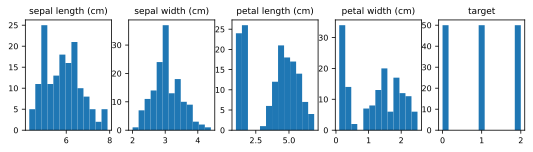

In [38]:
plt.figure(figsize=(9,2))
for (i,v) in enumerate(df.columns):
    plt.subplot(1,df.shape[1],i+1);
    plt.hist(df.iloc[:,i],bins="sqrt")
    plt.title(df.columns[i],fontsize=9);

Show correlation matrix

In [39]:
df.corr().round(2).style.background_gradient(cmap="viridis")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.120000,0.870000,0.820000,0.780000
sepal width (cm),-0.120000,1.000000,-0.430000,-0.370000,-0.430000
petal length (cm),0.870000,-0.430000,1.000000,0.960000,0.950000
petal width (cm),0.820000,-0.370000,0.960000,1.000000,0.960000
target,0.780000,-0.430000,0.950000,0.960000,1.000000


Scale and try to **reduce dimensions**: what we try to do is to **always simply the model** if possible (see correlation matrix above)
* More complex model (e.g., more features, or higher _*k*_) will (in theory) increase the probability of higher "out of sample" error (even when "in sample" error = train set) will be smaller!
* Use either 99% threshold (own subjective) or "mle" algorithm (more objective)
* Use **linear** scaler (transformation)
* Here, the data is scaled prior train-test split. 
    * In real applications, first split and scale afterwards, to simulate real-world scenario where we do not have the test set! (otherwise data snooping effect)

In [40]:
scale = StandardScaler(with_mean=True,with_std=True);
Xo = scale.fit_transform(df.drop(["target"],axis=1).values);

In [41]:
pca = PCA(n_components=0.99)# or set n_components="mle"
X = pca.fit_transform(Xo)
print("Nr. of features after PCA = {} (input = {})".format(X.shape[1],Xo.shape[1]))

Nr. of features after PCA = 3 (input = 4)


Prepare for fitting

In [42]:
# encode target values (is not necessary for IRIS but still:-)
y = LabelEncoder().fit_transform(df["target"].values);
# Split 2/3 to 1/3 train to test respectively
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size = 0.67,test_size = 0.33,
                                                   stratify=y,random_state=123);

#### Find optimal model
* Considering the small data set (150 samples), find "optimal" k setting it to maximum of 5
    * Optimal in terms of accuracy
    * Simple model = higher probability of lower in and out-of sample error

In [43]:
model = KNeighborsClassifier(algorithm="auto");
parameters = {"n_neighbors":[1,3,5],
              "weights":["uniform","distance"]}
model_optim = GridSearchCV(model, parameters, cv=5,scoring="accuracy");

In [44]:
model_optim.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Show the "optimal" settings for kNN

In [45]:
model_optim.best_estimator_

KNeighborsClassifier(n_neighbors=1)

#### Show resulting accuracy

In [46]:
for (i,x,y) in zip(["Train","Test"],[X_train,X_test],[y_train,y_test]):
    print("Classification kNN",i," report:\n",classification_report(y,model_optim.predict(x)))

Classification kNN Train  report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Classification kNN Test  report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.88      0.94        17
           2       0.89      1.00      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In this case, the precision (accuracy=macro avg precision) is very high. 
Just to show that that is not coincidence compare to "dummy" model (most frequent & uniform distribution)

In [47]:
for i in ["most_frequent","uniform"]:
    dummy = DummyClassifier(strategy=i).fit(X_train,y_train);
    print("Classification ",i," test report:",classification_report(y_test,dummy.predict(X_test)))

Classification  most_frequent  test report:               precision    recall  f1-score   support

           0       0.32      1.00      0.48        16
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        17

    accuracy                           0.32        50
   macro avg       0.11      0.33      0.16        50
weighted avg       0.10      0.32      0.16        50

Classification  uniform  test report:               precision    recall  f1-score   support

           0       0.42      0.50      0.46        16
           1       0.45      0.53      0.49        17
           2       0.45      0.29      0.36        17

    accuracy                           0.44        50
   macro avg       0.44      0.44      0.43        50
weighted avg       0.44      0.44      0.43        50



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Load data

In [48]:
# house = datasets.fetch_california_housing()
# df = pd.DataFrame(house.data,columns=house.feature_names)
# df = df.assign(target=house.target)

In [49]:
df = pd.read_csv("../input/test-data/california_housing.csv").drop(columns=["Unnamed: 0"],errors='ignore')

FileNotFoundError: [Errno 2] No such file or directory: '../input/test-data/california_housing.csv'

In [ ]:
import os
print(os.getcwd())

/Users/isabellaw/Desktop/k-Nearest Neighbour


Inspect data: show statistics, histogram and correlation 

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Compute selected stats
dfinfo = pd.DataFrame(df.dtypes, columns=["dtypes"])
for (m, n) in zip([df.count(), df.isna().sum()], ["count", "isna"]):
    dfinfo = dfinfo.merge(pd.DataFrame(m, columns=[n]), right_index=True, left_index=True, how="inner")

# Correct approach: Concatenate dfinfo.T with df.describe() along the columns (axis=0 for vertical)
combined_df = pd.concat([dfinfo.T, df.describe()], axis=0)

combined_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
dtypes,float64,float64,float64,float64,int64
count,150,150,150,150,150
isna,0,0,0,0,0
count,150.0,150.0,150.0,150.0,150.0
mean,5.843333,3.057333,3.758,1.199333,1.0
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.3,2.0,1.0,0.1,0.0
25%,5.1,2.8,1.6,0.3,0.0
50%,5.8,3.0,4.35,1.3,1.0
75%,6.4,3.3,5.1,1.8,2.0


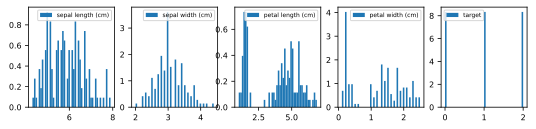

In [ ]:
plt.figure(figsize=(9,4))
for (i,v) in enumerate(df.columns):
    plt.subplot(2,5,i+1);
    plt.hist(df.iloc[:,i],50,density=True)
    plt.legend([df.columns[i]],fontsize=6);

In [ ]:
df.corr().round(2).style.background_gradient(cmap="viridis")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.120000,0.870000,0.820000,0.780000
sepal width (cm),-0.120000,1.000000,-0.430000,-0.370000,-0.430000
petal length (cm),0.870000,-0.430000,1.000000,0.960000,0.950000
petal width (cm),0.820000,-0.370000,0.960000,1.000000,0.960000
target,0.780000,-0.430000,0.950000,0.960000,1.000000


#### Supervised Reduction
* Considering the correlation, histogram and the summary table:
    * Remove/drop "AveOccup" (average house occupancy)

In [ ]:
df = df.drop(["AveOccup"],axis=1)

KeyError: "['AveOccup'] not found in axis"

Prepare for fitting by scaling data set
* Here, the data is scaled prior train-test split. 
    * In real applications, first split and scale afterwards, to simulate real-world scenario where we do not have the test set!

In [ ]:
X = StandardScaler().fit_transform(df.drop("target",axis=1).values);
y = df.target.values

In [ ]:
X = PCA(n_components="mle").fit_transform(X)
print("Nr. of features after reduction = {} (input = {})".format(X.shape[1],df.shape[1]))

Nr. of features after reduction = 3 (input = 5)


#### Fit model

In [ ]:
[X_train,X_test,y_train,y_test] = train_test_split(X,y,train_size=0.67,test_size=0.33,
                                                   random_state=123);

In [ ]:
knn = KNeighborsRegressor();
parameters = {"n_neighbors":[1,3,5,7,9],
              "weights":["uniform","distance"]}
knn_reg = GridSearchCV(knn, parameters, cv=5, scoring="neg_mean_squared_error");

In [ ]:
knn_reg.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
knn_reg.best_estimator_

KNeighborsRegressor(weights='distance')

In [ ]:
print("Regression kNN (test) RMSE \t= {:.0f} *1000$".format(
    100*np.sqrt(mean_squared_error(knn_reg.predict(X_test),y_test))))

Regression kNN (test) RMSE 	= 18 *1000$


Compare to dummy

In [ ]:
for i in ["mean","median"]:
    dummy = DummyRegressor(strategy=i).fit(X_train,y_train);
    print("Regression ",i,"(test) RMSE \t= {:.0f} *1000$".format(
        100*np.sqrt(mean_squared_error(y_test,dummy.predict(X_test)))))

Regression  mean (test) RMSE 	= 88 *1000$
Regression  median (test) RMSE 	= 88 *1000$
